<b>feature importance</b>
- permutation importance
- 특징 : feature을 제거하는 대신, 특정 feature를 섰어서 특정 feature 노이즈로 만드는 것이다. 만약 feature을 shuffle했을 때 target과 연결고리가 끊어지는 것이기 때문에 모델 성능이 떨어지면 중요한 feature이고, 모델 성능이 그대로거나 좋지 않게 되면 not good feature이다.
- 장점 : 모델을 재학습시킬 필요가 없다
- 단점 : 특정 feature을 무작위로 섞기 때문에 실행마다 feature importance가 달라질 수 있다. 따라서 permutation 적절한 횟수를 선택해야 한다.

- feature를 무작위로 섞다 보면 매우 비현실적인 데이터 조합이 생성될 가능성이 크다.
- 예를 들어, 키와 몸무게가 있을 때 상식적으로 상당한 연관성이 존재하는데, 이렇게 해서 중요도가 높게 나온다고 해도 우리가 원하던 feature importance가 아닐 수 있다.
- 따라서 미리 변수들 간의 상관관계가 매우 높은지 확인하고, 이를 염두에 두고 결과를 해석해야 합니다.

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# 한글 폰트 깨짐 방지
import warnings
import platform
from matplotlib import font_manager, rc
## 운영체제별 글꼴 세팅
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    font_name = 'AppleGothic'
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    font_name = font_manager.FontProperties(fname="/usr/share/fonts/nanumfont/NanumGothic.ttf")
    rc('font', family="NanumGothic")
warnings.simplefilter(action='ignore')

### 데이터 불러오기

In [6]:
os.getcwd()

'C:\\Users\\SAMSUNG\\Desktop\\SSAC\\머신러닝\\강의자료_python'

In [24]:
yy = pd.read_csv('C:\\Users\SAMSUNG\Desktop\SSAC\머신러닝\메인프로젝트/4.체감안전도_통계(2017_2019)_processed.csv')
yy = yy[yy.year != '2016(이전)']
yy.year.unique()

array(['2017(상반기)', '2017(하반기)', '2018(상반기)', '2018(하반기)', '2019(상반기)',
       '2019(하반기)', '2020(상반기)', '2020(하반기)'], dtype=object)

In [25]:
yy = yy[(yy.year != '2020(상반기)') & (yy.year != '2020(하반기)')]
yy.year.unique()

array(['2017(상반기)', '2017(하반기)', '2018(상반기)', '2018(하반기)', '2019(상반기)',
       '2019(하반기)'], dtype=object)

In [10]:
yy.drop(['jur_stn','year'], axis = 1, inplace = True)
yy

,q1,q2,q3,q4,q5
41,75.2,76.5,69.9,65.9,72.6
42,81.6,82.4,69.1,62.7,72.2
43,77.3,79.3,68.8,61.0,71.7
44,78.0,80.0,67.0,66.3,71.4
45,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...
282,79.1,79.5,68.5,71.2,76.0
283,80.8,80.0,70.8,73.2,76.5
284,75.0,76.5,69.4,68.9,73.1
285,78.7,79.6,70.3,74.6,75.6


In [134]:
df = pd.read_csv('C:\\Users\SAMSUNG\Desktop\SSAC\머신러닝\메인프로젝트/total_data(2016제외).csv')
df

,jur_stn,year,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,...,single_f_2030,single_f_4050,single_f_o60,adult,bell,q1,q2,q3,q4,q5
0,서울중부경찰서,2017(상반기),13404.0,3239.0,5931.0,22574.0,1324.0,0.0,1412.0,3275.0,...,2128.000000,1230.500000,1635.500000,0.0,0.0,75.2,76.5,69.9,65.9,72.6
1,서울종로경찰서,2017(상반기),11579.0,2560.0,5534.0,19674.0,1102.0,0.0,867.0,2914.0,...,2703.000000,1378.500000,1782.500000,2.0,2.0,81.6,82.4,69.1,62.7,72.2
2,서울남대문경찰서,2017(상반기),9093.0,1855.0,3551.0,14499.0,949.0,0.0,736.0,2506.0,...,2128.000000,1230.500000,1635.500000,0.0,0.0,77.3,79.3,68.8,61.0,71.7
3,서울서대문경찰서,2017(상반기),18441.0,10029.0,10298.0,38769.0,1924.0,0.0,1788.0,4267.0,...,12420.000000,4496.000000,7066.000000,0.0,0.0,78.0,80.0,67.0,66.3,71.4
4,서울혜화경찰서,2017(상반기),10829.0,2989.0,5038.0,18857.0,1127.0,0.0,899.0,2864.0,...,2703.000000,1378.500000,1782.500000,0.0,0.0,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,창원서부경찰서,2020(하반기),11915.0,2751.0,6897.0,21563.0,1282.0,1.0,1984.0,2686.0,...,2844.333333,4446.333333,5225.333333,0.0,0.0,NaN,NaN,NaN,NaN,NaN
324,마산중부경찰서,2020(하반기),9913.0,2094.0,5405.0,17412.0,1107.0,1.0,1301.0,1933.0,...,1960.333333,2944.666667,6789.000000,5.0,5.0,NaN,NaN,NaN,NaN,NaN
325,마산동부경찰서,2020(하반기),13687.0,3432.0,6906.0,24025.0,1430.0,4.0,1919.0,2502.0,...,1498.000000,3108.666667,5798.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN
326,진주경찰서,2020(하반기),18826.0,4426.0,11375.0,34627.0,2347.0,2.0,3169.0,3948.0,...,5721.333333,5282.000000,11301.000000,2.0,2.0,NaN,NaN,NaN,NaN,NaN


In [135]:
df = df[(df['year'] != '2020(상반기)') & (df['year'] != '2020(하반기)')]
df.year.unique()

array(['2017(상반기)', '2017(하반기)', '2018(상반기)', '2018(하반기)', '2019(상반기)',
       '2019(하반기)'], dtype=object)

In [138]:
y_q1 = yy.q1
y_q2 = yy.q2
y_q3 = yy.q3
y_q4 = yy.q4
y_q5 = yy.q5

In [141]:
df.drop(['q1','q2','q3','q4','q5'], axis = 1, inplace = True)

In [143]:
df.drop(['jur_stn','year'], axis = 1, inplace = True)

In [123]:
X_train = df[(df['year'] != '2019(상반기)') & (df['year'] != '2019(하반기)')]
y_train = yy[(yy['year'] != '2019(상반기)') & (yy['year'] != '2019(하반기)')]

#### standardscaler 정규화

In [144]:
df

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,13404.0,3239.0,5931.0,22574.0,1324.0,0.0,1412.0,3275.0,572.0,4.0,...,4310.5,2954.5,2567.5,5169.0,175.0,2128.0,1230.5,1635.5,0.0,0.0
1,11579.0,2560.0,5534.0,19674.0,1102.0,0.0,867.0,2914.0,525.0,2.0,...,5483.5,3220.5,2861.5,6022.0,158.0,2703.0,1378.5,1782.5,2.0,2.0
2,9093.0,1855.0,3551.0,14499.0,949.0,0.0,736.0,2506.0,413.0,0.0,...,4310.5,2954.5,2567.5,5169.0,175.0,2128.0,1230.5,1635.5,0.0,0.0
3,18441.0,10029.0,10298.0,38769.0,1924.0,0.0,1788.0,4267.0,674.0,0.0,...,23040.0,9687.0,9894.0,24527.0,545.0,12420.0,4496.0,7066.0,0.0,0.0
4,10829.0,2989.0,5038.0,18857.0,1127.0,0.0,899.0,2864.0,427.0,4.0,...,5483.5,3220.5,2861.5,6022.0,158.0,2703.0,1378.5,1782.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,12630.0,2990.0,7151.0,22771.0,1460.0,2.0,1964.0,2142.0,363.0,2.0,...,8529.0,10946.0,8555.0,13016.0,50.0,2900.0,4492.0,5574.0,1.0,1.0
242,12223.0,2552.0,6489.0,21264.0,1265.0,5.0,1584.0,1369.0,151.0,3.0,...,5895.0,6580.0,10395.0,12431.0,192.0,2216.0,2837.0,7186.0,3.0,3.0
243,15177.0,3190.0,7647.0,26014.0,1715.0,8.0,1910.0,1920.0,312.0,6.0,...,3791.0,7160.0,9299.0,10643.0,42.0,1496.0,2939.0,6166.0,1.0,1.0
244,21840.0,5262.0,11455.0,38557.0,2552.0,0.0,3570.0,2876.0,537.0,0.0,...,15178.0,11882.0,16273.0,23362.0,308.0,6026.0,5205.0,11823.0,8.0,8.0


In [145]:
scaler = StandardScaler()

scaled = scaler.fit_transform(df)
df_sc = pd.DataFrame(scaled, columns = df.columns)
df_sc

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,-0.402208,0.020461,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
1,-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,-0.545798,-0.698583,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,0.299434,0.299434
2,-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,-0.887971,-1.417626,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
3,-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,-0.090585,-1.417626,...,0.492436,-0.139220,0.116044,0.542183,1.457752,0.708900,0.029251,0.221012,-0.593423,-0.593423
4,-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,-0.845200,0.020461,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,-1.040727,-0.698583,...,-0.669920,0.142481,-0.186938,-0.617883,-0.901442,-0.845594,0.027122,-0.265578,-0.146995,-0.146995
242,-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,-1.688412,-0.339061,...,-0.880908,-0.834410,0.229408,-0.676839,-0.224663,-0.957283,-0.853710,0.260147,0.745862,0.745862
243,-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,-1.196538,0.739504,...,-1.049442,-0.704635,-0.018589,-0.857031,-0.939570,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995
244,0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,-0.509137,-1.417626,...,-0.137324,0.351911,1.559452,0.424776,0.328199,-0.335158,0.406598,1.772423,2.978006,2.978006


### X_train, y_train, X_test, y_test 설정

In [ ]:
163까지 train 164부터 test

In [155]:
X_train = df_sc.iloc[:164,:]
X_test = df_sc.iloc[164:,:]

In [156]:
X_train

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,-0.402208,0.020461,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
1,-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,-0.545798,-0.698583,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,0.299434,0.299434
2,-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,-0.887971,-1.417626,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
3,-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,-0.090585,-1.417626,...,0.492436,-0.139220,0.116044,0.542183,1.457752,0.708900,0.029251,0.221012,-0.593423,-0.593423
4,-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,-0.845200,0.020461,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,-1.043485,-1.133855,-0.834329,-1.014189,-0.959106,0.290759,-0.328937,-0.699669,-0.836034,-0.339061,...,-0.711253,0.114513,-0.313426,-0.673211,-0.896676,-0.865515,-0.011731,-0.381355,0.299434,0.299434
160,-1.118572,-1.322219,-1.116538,-1.169875,-1.099634,1.909011,-0.870679,-1.092141,-1.297357,1.818068,...,-0.948834,-0.785857,0.091380,-0.754035,-0.596415,-1.024067,-0.785053,0.127086,0.745862,0.745862
161,-0.991747,-1.327673,-1.004194,-1.064648,-0.897829,-0.032891,-0.614016,-0.781164,-0.701609,-0.698583,...,-1.040150,-0.634378,-0.171778,-0.888575,-0.996763,-1.078768,-0.710009,-0.217636,-0.593423,-0.593423
162,-0.333722,-0.072894,-0.142616,-0.243879,-0.159240,1.585360,0.504301,0.027279,0.605981,0.739504,...,-0.230162,0.363770,1.387936,0.334276,0.576033,-0.421537,0.445983,1.610987,0.299434,0.299434


In [153]:
y_train_q1

,q1
41,75.2
42,81.6
43,77.3
44,78.0
45,78.6
...,...
200,74.2
201,76.9
202,72.4
203,80.9


In [147]:
y_test_q1

,q1
205,77.5
206,85.8
207,81.2
208,80.4
209,76.5
...,...
282,79.1
283,80.8
284,75.0
285,78.7


In [150]:
X_test

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
164,-0.824473,-0.766357,-1.085389,-0.910211,-1.090646,0.290759,-0.848679,-0.576678,-0.270837,0.020461,...,-0.961170,-1.633533,-1.468107,-1.355131,-0.365261,-0.914338,-1.689303,-1.499010,-0.593423,-0.593423
165,-0.830502,-0.989541,-0.999210,-0.920952,-0.954204,-0.032891,-1.212590,-0.885156,-0.857420,-0.339061,...,-0.884432,-1.596502,-1.430998,-1.288214,-0.308069,-0.840451,-1.617452,-1.477974,-0.593423,-0.593423
166,-1.213390,-1.252160,-1.505899,-1.330557,-1.358630,0.290759,-1.336338,-0.974650,-0.515247,-1.417626,...,-0.961170,-1.633533,-1.468107,-1.355131,-0.365261,-0.914338,-1.689303,-1.499010,-0.593423,-0.593423
167,-0.200320,2.343951,-0.097969,0.205318,-0.491768,-0.356542,-0.413269,-0.224703,-0.096696,0.020461,...,0.635578,-0.096260,0.366078,0.719655,1.386261,0.864513,0.101633,0.445064,-0.593423,-0.593423
168,-1.095663,-0.668610,-1.270206,-1.105740,-1.277745,-0.680192,-1.318005,-1.017147,-0.949074,-1.417626,...,-0.884432,-1.596502,-1.430998,-1.288214,-0.308069,-0.840451,-1.617452,-1.477974,-0.146995,-0.146995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,-1.040727,-0.698583,...,-0.669920,0.142481,-0.186938,-0.617883,-0.901442,-0.845594,0.027122,-0.265578,-0.146995,-0.146995
242,-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,-1.688412,-0.339061,...,-0.880908,-0.834410,0.229408,-0.676839,-0.224663,-0.957283,-0.853710,0.260147,0.745862,0.745862
243,-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,-1.196538,0.739504,...,-1.049442,-0.704635,-0.018589,-0.857031,-0.939570,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995
244,0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,-0.509137,-1.417626,...,-0.137324,0.351911,1.559452,0.424776,0.328199,-0.335158,0.406598,1.772423,2.978006,2.978006


In [126]:
y_test_q1 = y_test.drop(['jur_stn','year','q2','q3','q4','q5'], axis = 1)

In [127]:
X_test.drop(['jur_stn','year'], axis = 1, inplace = True)

In [128]:
y_test.drop(['jur_stn','year'], axis = 1, inplace = True)

### XGBoost 모델링

#### 전체 columns 다 넣었을 때

In [209]:
os.getcwd()

'C:\\Users\\SAMSUNG\\Desktop\\SSAC\\머신러닝\\강의자료_python'

In [157]:
a = xgb.XGBClassifier(random_state = 1)

In [158]:
xgb_model = a.fit(X_train, y_train_q1)

[16:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [159]:
pred = xgb_model.predict(X_test)

In [160]:
mae = mean_absolute_error(y_test_q1, pred)
mse = mean_squared_error(y_test_q1, pred)

In [161]:
print(mae, mse)

2.8207317073170746 14.451097560975615


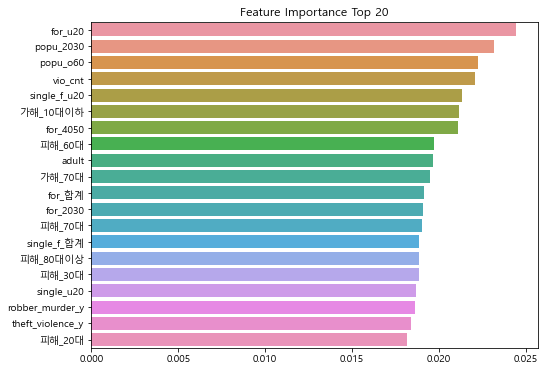

In [162]:
#q1
# # 모델 내장 함수 사용
# model = XGBClassifier(random_state=11)
# model.fit(df, y_q1)

# 배열형태로 반환
ft_importance_values = a.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

### corr 0.15 이상인 columns만 가져와서 모델링해보기

In [170]:
df_cor15 = pd.read_csv('C:\\Users\SAMSUNG\Desktop\SSAC\머신러닝\메인프로젝트/total_data(2016제외).csv')
df_cor15

,jur_stn,year,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,...,single_f_2030,single_f_4050,single_f_o60,adult,bell,q1,q2,q3,q4,q5
0,서울중부경찰서,2017(상반기),13404.0,3239.0,5931.0,22574.0,1324.0,0.0,1412.0,3275.0,...,2128.000000,1230.500000,1635.500000,0.0,0.0,75.2,76.5,69.9,65.9,72.6
1,서울종로경찰서,2017(상반기),11579.0,2560.0,5534.0,19674.0,1102.0,0.0,867.0,2914.0,...,2703.000000,1378.500000,1782.500000,2.0,2.0,81.6,82.4,69.1,62.7,72.2
2,서울남대문경찰서,2017(상반기),9093.0,1855.0,3551.0,14499.0,949.0,0.0,736.0,2506.0,...,2128.000000,1230.500000,1635.500000,0.0,0.0,77.3,79.3,68.8,61.0,71.7
3,서울서대문경찰서,2017(상반기),18441.0,10029.0,10298.0,38769.0,1924.0,0.0,1788.0,4267.0,...,12420.000000,4496.000000,7066.000000,0.0,0.0,78.0,80.0,67.0,66.3,71.4
4,서울혜화경찰서,2017(상반기),10829.0,2989.0,5038.0,18857.0,1127.0,0.0,899.0,2864.0,...,2703.000000,1378.500000,1782.500000,0.0,0.0,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,창원서부경찰서,2020(하반기),11915.0,2751.0,6897.0,21563.0,1282.0,1.0,1984.0,2686.0,...,2844.333333,4446.333333,5225.333333,0.0,0.0,NaN,NaN,NaN,NaN,NaN
324,마산중부경찰서,2020(하반기),9913.0,2094.0,5405.0,17412.0,1107.0,1.0,1301.0,1933.0,...,1960.333333,2944.666667,6789.000000,5.0,5.0,NaN,NaN,NaN,NaN,NaN
325,마산동부경찰서,2020(하반기),13687.0,3432.0,6906.0,24025.0,1430.0,4.0,1919.0,2502.0,...,1498.000000,3108.666667,5798.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN
326,진주경찰서,2020(하반기),18826.0,4426.0,11375.0,34627.0,2347.0,2.0,3169.0,3948.0,...,5721.333333,5282.000000,11301.000000,2.0,2.0,NaN,NaN,NaN,NaN,NaN


In [171]:
df_cor15 = df_cor15[(df_cor15['year'] != '2020(상반기)') & (df_cor15['year'] != '2020(하반기)')]
df_cor15.year.unique()

array(['2017(상반기)', '2017(하반기)', '2018(상반기)', '2018(하반기)', '2019(상반기)',
       '2019(하반기)'], dtype=object)

In [172]:
df_score = df_cor15.iloc[:,-5:]
df_score

,q1,q2,q3,q4,q5
0,75.2,76.5,69.9,65.9,72.6
1,81.6,82.4,69.1,62.7,72.2
2,77.3,79.3,68.8,61.0,71.7
3,78.0,80.0,67.0,66.3,71.4
4,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...
241,79.1,79.5,68.5,71.2,76.0
242,80.8,80.0,70.8,73.2,76.5
243,75.0,76.5,69.4,68.9,73.1
244,78.7,79.6,70.3,74.6,75.6


In [174]:
df_cor15.drop(['q1','q2','q3','q4','q5'], axis = 1, inplace = True)

In [173]:
df_juryear = df_cor15.iloc[:,:2]
df_juryear

,jur_stn,year
0,서울중부경찰서,2017(상반기)
1,서울종로경찰서,2017(상반기)
2,서울남대문경찰서,2017(상반기)
3,서울서대문경찰서,2017(상반기)
4,서울혜화경찰서,2017(상반기)
...,...,...
241,창원서부경찰서,2019(하반기)
242,마산중부경찰서,2019(하반기)
243,마산동부경찰서,2019(하반기)
244,진주경찰서,2019(하반기)


In [175]:
df_cor15.drop(['jur_stn','year'], axis = 1, inplace = True)

In [176]:
scaler = StandardScaler()

scaled = scaler.fit_transform(df_cor15)
df_sc2 = pd.DataFrame(scaled, columns = df_cor15.columns)
df_sc2

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,-0.402208,0.020461,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
1,-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,-0.545798,-0.698583,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,0.299434,0.299434
2,-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,-0.887971,-1.417626,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
3,-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,-0.090585,-1.417626,...,0.492436,-0.139220,0.116044,0.542183,1.457752,0.708900,0.029251,0.221012,-0.593423,-0.593423
4,-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,-0.845200,0.020461,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,-1.040727,-0.698583,...,-0.669920,0.142481,-0.186938,-0.617883,-0.901442,-0.845594,0.027122,-0.265578,-0.146995,-0.146995
242,-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,-1.688412,-0.339061,...,-0.880908,-0.834410,0.229408,-0.676839,-0.224663,-0.957283,-0.853710,0.260147,0.745862,0.745862
243,-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,-1.196538,0.739504,...,-1.049442,-0.704635,-0.018589,-0.857031,-0.939570,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995
244,0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,-0.509137,-1.417626,...,-0.137324,0.351911,1.559452,0.424776,0.328199,-0.335158,0.406598,1.772423,2.978006,2.978006


In [179]:
temp = pd.merge(df_juryear, df_sc2, left_index = True, right_index = True, how = 'left')
temp

,jur_stn,year,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,서울중부경찰서,2017(상반기),-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
1,서울종로경찰서,2017(상반기),-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,0.299434,0.299434
2,서울남대문경찰서,2017(상반기),-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,...,-1.007829,-1.645615,-1.541759,-1.408695,-0.305686,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423
3,서울서대문경찰서,2017(상반기),-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,...,0.492436,-0.139220,0.116044,0.542183,1.457752,0.708900,0.029251,0.221012,-0.593423,-0.593423
4,서울혜화경찰서,2017(상반기),-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,...,-0.913870,-1.586098,-1.475235,-1.322731,-0.386709,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,창원서부경찰서,2019(하반기),-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,...,-0.669920,0.142481,-0.186938,-0.617883,-0.901442,-0.845594,0.027122,-0.265578,-0.146995,-0.146995
242,마산중부경찰서,2019(하반기),-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,...,-0.880908,-0.834410,0.229408,-0.676839,-0.224663,-0.957283,-0.853710,0.260147,0.745862,0.745862
243,마산동부경찰서,2019(하반기),-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,...,-1.049442,-0.704635,-0.018589,-0.857031,-0.939570,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995
244,진주경찰서,2019(하반기),0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,...,-0.137324,0.351911,1.559452,0.424776,0.328199,-0.335158,0.406598,1.772423,2.978006,2.978006


In [180]:
df_merge_cor15 = pd.merge(temp, df_score, left_index = True, right_index = True, how = 'left')
df_merge_cor15

,jur_stn,year,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,...,single_f_2030,single_f_4050,single_f_o60,adult,bell,q1,q2,q3,q4,q5
0,서울중부경찰서,2017(상반기),-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,...,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423,75.2,76.5,69.9,65.9,72.6
1,서울종로경찰서,2017(상반기),-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,...,-0.877762,-1.629960,-1.502108,0.299434,0.299434,81.6,82.4,69.1,62.7,72.2
2,서울남대문경찰서,2017(상반기),-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,...,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423,77.3,79.3,68.8,61.0,71.7
3,서울서대문경찰서,2017(상반기),-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,...,0.708900,0.029251,0.221012,-0.593423,-0.593423,78.0,80.0,67.0,66.3,71.4
4,서울혜화경찰서,2017(상반기),-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,...,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,창원서부경찰서,2019(하반기),-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,...,-0.845594,0.027122,-0.265578,-0.146995,-0.146995,79.1,79.5,68.5,71.2,76.0
242,마산중부경찰서,2019(하반기),-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,...,-0.957283,-0.853710,0.260147,0.745862,0.745862,80.8,80.0,70.8,73.2,76.5
243,마산동부경찰서,2019(하반기),-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,...,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995,75.0,76.5,69.4,68.9,73.1
244,진주경찰서,2019(하반기),0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,...,-0.335158,0.406598,1.772423,2.978006,2.978006,78.7,79.6,70.3,74.6,75.6


In [181]:
df_merge_cor15.drop(['jur_stn','year'], axis = 1, inplace = True)
df_merge_cor15

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_f_2030,single_f_4050,single_f_o60,adult,bell,q1,q2,q3,q4,q5
0,-0.873690,-0.812504,-1.088919,-0.946182,-1.080025,-0.680192,-0.925678,-0.533681,-0.402208,0.020461,...,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423,75.2,76.5,69.9,65.9,72.6
1,-1.073739,-1.097357,-1.171360,-1.127285,-1.261404,-0.680192,-1.425254,-0.714168,-0.545798,-0.698583,...,-0.877762,-1.629960,-1.502108,0.299434,0.299434,81.6,82.4,69.1,62.7,72.2
2,-1.346245,-1.393118,-1.583148,-1.450459,-1.386409,-0.680192,-1.545335,-0.918154,-0.887971,-1.417626,...,-0.971652,-1.708729,-1.550049,-0.593423,-0.593423,77.3,79.3,68.8,61.0,71.7
3,-0.321555,2.036024,-0.182071,0.065182,-0.589811,-0.680192,-0.581016,-0.037717,-0.090585,-1.417626,...,0.708900,0.029251,0.221012,-0.593423,-0.593423,78.0,80.0,67.0,66.3,71.4
4,-1.155951,-0.917384,-1.274359,-1.178306,-1.240979,-0.680192,-1.395921,-0.739167,-0.845200,0.020461,...,-0.877762,-1.629960,-1.502108,-0.593423,-0.593423,78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.958533,-0.916965,-0.835575,-0.933879,-0.968910,-0.032891,-0.419685,-1.100141,-1.040727,-0.698583,...,-0.845594,0.027122,-0.265578,-0.146995,-0.146995,79.1,79.5,68.5,71.2,76.0
242,-1.003147,-1.100714,-0.973045,-1.027990,-1.128230,0.938060,-0.768014,-1.486613,-1.688412,-0.339061,...,-0.957283,-0.853710,0.260147,0.745862,0.745862,80.8,80.0,70.8,73.2,76.5
243,-0.679341,-0.833061,-0.732576,-0.731357,-0.760569,1.909011,-0.469185,-1.211133,-1.196538,0.739504,...,-1.074850,-0.799423,-0.072507,-0.146995,-0.146995,75.0,76.5,69.4,68.9,73.1
244,0.051030,0.036181,0.058191,0.051943,-0.076720,-0.680192,1.052459,-0.733167,-0.509137,-1.417626,...,-0.335158,0.406598,1.772423,2.978006,2.978006,78.7,79.6,70.3,74.6,75.6


##### Q1

In [182]:
q1_co = df_merge_cor15.corr().iloc[:,-5]
q1df = pd.DataFrame(q1_co[abs(q1_co) > 0.15])
q1df

,q1
report_sx_여성,-0.172464
vio_cnt,-0.273450
theft_violence_x,-0.161434
robber_murder_x,-0.173866
theft_violence_y,-0.225929
robber_murder_y,-0.181060
가해_10대이하,-0.218850
피해_80대이상,-0.279847
for_합계,-0.419146
popu_2030,-0.161250


In [183]:
q1df.index

Index(['report_sx_여성', 'vio_cnt', 'theft_violence_x', 'robber_murder_x',
       'theft_violence_y', 'robber_murder_y', '가해_10대이하', '피해_80대이상', 'for_합계',
       'popu_2030', 'popu_o60', 'for_u20', 'for_2030', 'for_4050', 'for_o60',
       'single_합계', 'single_2030', 'single_4050', 'single_o60', 'single_f_합계',
       'single_f_4050', 'single_f_o60', 'q1', 'q2', 'q3', 'q4', 'q5'],
      dtype='object')

In [186]:
q1_df = df_merge_cor15[q1df.index]
q1_df.drop(['q1','q2','q3','q4','q5'], axis = 1, inplace = True)

In [188]:
q1_df

,report_sx_여성,vio_cnt,theft_violence_x,robber_murder_x,theft_violence_y,robber_murder_y,가해_10대이하,피해_80대이상,for_합계,popu_2030,...,for_2030,for_4050,for_o60,single_합계,single_2030,single_4050,single_o60,single_f_합계,single_f_4050,single_f_o60
0,-1.088919,-1.080025,-0.402208,0.020461,-0.948579,-0.450180,-1.087188,-1.000338,-0.553026,-1.607630,...,-0.715257,-0.444718,-0.389120,-1.382521,-1.007829,-1.645615,-1.541759,-1.408695,-1.708729,-1.550049
1,-1.171360,-1.261404,-0.545798,-0.698583,-1.100422,-0.117615,-1.179444,-0.799618,-0.517983,-1.518672,...,-0.536311,-0.489417,-0.457047,-1.293277,-0.913870,-1.586098,-1.475235,-1.322731,-1.629960,-1.502108
2,-1.583148,-1.386409,-0.887971,-1.417626,-1.013655,-1.447878,-1.363955,-1.401779,-0.553026,-1.607630,...,-0.715257,-0.444718,-0.389120,-1.382521,-1.007829,-1.645615,-1.541759,-1.408695,-1.708729,-1.550049
3,-0.182071,-0.589811,-0.090585,-1.417626,-0.167671,-1.115312,0.204387,0.003264,0.234176,0.366947,...,1.038446,-0.246735,-0.231116,0.330221,0.492436,-0.139220,0.116044,0.542183,0.029251,0.221012
4,-1.274359,-1.240979,-0.845200,0.020461,-1.306495,0.214951,-1.271699,-1.000338,-0.517983,-1.518672,...,-0.536311,-0.489417,-0.457047,-1.293277,-0.913870,-1.586098,-1.475235,-1.322731,-1.629960,-1.502108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.835575,-0.968910,-1.040727,-0.698583,-0.183940,-0.782746,-0.994933,-0.398177,-0.556217,-0.453409,...,-0.549082,-0.443242,-0.559921,-0.454991,-0.669920,0.142481,-0.186938,-0.617883,0.027122,-0.265578
242,-0.973045,-1.128230,-1.688412,-0.339061,-1.382417,-0.117615,-0.810422,0.003264,-0.748121,-1.107129,...,-0.866708,-0.603906,-0.612097,-0.699140,-0.880908,-0.834410,0.229408,-0.676839,-0.853710,0.260147
243,-0.732576,-0.760569,-1.196538,0.739504,-0.807582,0.547517,-0.994933,-0.598897,-0.775018,-1.043563,...,-0.931015,-0.615713,-0.590931,-0.855946,-1.049442,-0.704635,-0.018589,-0.857031,-0.799423,-0.072507
244,0.058191,-0.076720,-0.509137,-1.417626,0.293281,-1.447878,-0.164635,0.806145,-0.354790,0.063285,...,0.027572,-0.463272,-0.557460,0.360277,-0.137324,0.351911,1.559452,0.424776,0.406598,1.772423


In [189]:
X_train = q1_df.iloc[:164,:]
X_test = q1_df.iloc[164:,:]

In [190]:
a = xgb.XGBClassifier(random_state = 0)

In [191]:
xgb_model = a.fit(X_train, y_train_q1)

[17:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [192]:
pred = xgb_model.predict(X_test)

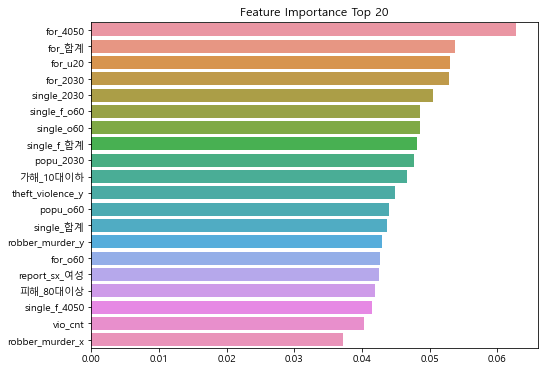

In [193]:
#q1
# # 모델 내장 함수 사용
# model = XGBClassifier(random_state=11)
# model.fit(df, y_q1)

# 배열형태로 반환
ft_importance_values = a.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [194]:
ft_top20.index

Index(['for_4050', 'for_합계', 'for_u20', 'for_2030', 'single_2030',
       'single_f_o60', 'single_o60', 'single_f_합계', 'popu_2030', '가해_10대이하',
       'theft_violence_y', 'popu_o60', 'single_합계', 'robber_murder_y',
       'for_o60', 'report_sx_여성', '피해_80대이상', 'single_f_4050', 'vio_cnt',
       'robber_murder_x'],
      dtype='object')

### Q2

In [195]:
q2_co = df_merge_cor15.corr().iloc[:,-4]
q2df = pd.DataFrame(q2_co[abs(q2_co) > 0.15])
q2df

,q2
report_sx_여성,-0.180158
vio_cnt,-0.275363
theft_violence_x,-0.170231
robber_murder_x,-0.212126
theft_violence_y,-0.242311
robber_murder_y,-0.205024
가해_10대이하,-0.186838
피해_80대이상,-0.234227
for_합계,-0.375512
popu_o60,-0.180430


In [196]:
q2_df = df_merge_cor15[q2df.index]
q2_df.drop(['q1','q2','q3','q4','q5'], axis = 1, inplace = True)

In [198]:
X_train_cor15_q2 = q2_df.iloc[:164,:]
X_test_cor15_q2 = q2_df.iloc[164:,:]

In [203]:
y_train_q2 = y_train.q2
y_train_q2

41     76.5
42     82.4
43     79.3
44     80.0
45     80.6
       ... 
200    77.3
201    77.4
202    75.6
203    83.0
204    79.8
Name: q2, Length: 164, dtype: float64

In [204]:
a = xgb.XGBClassifier(random_state = 0)

xgb_model = a.fit(X_train_cor15_q2, y_train_q2)

pred = xgb_model.predict(X_test_cor15_q2)

[17:07:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


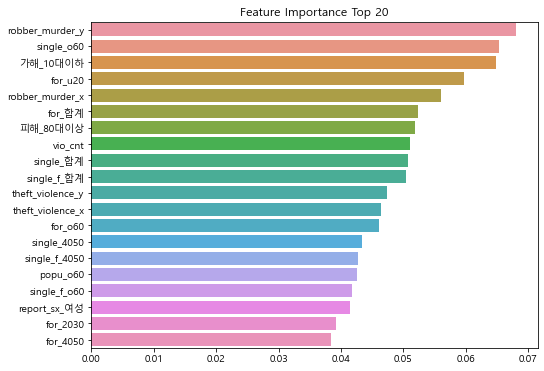

In [205]:
#q2

# 배열형태로 반환
ft_importance_values = a.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train_cor15_q2.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [206]:
ft_top20.index

Index(['robber_murder_y', 'single_o60', '가해_10대이하', 'for_u20',
       'robber_murder_x', 'for_합계', '피해_80대이상', 'vio_cnt', 'single_합계',
       'single_f_합계', 'theft_violence_y', 'theft_violence_x', 'for_o60',
       'single_4050', 'single_f_4050', 'popu_o60', 'single_f_o60',
       'report_sx_여성', 'for_2030', 'for_4050'],
      dtype='object')

### Feature Importance
- Permutation importance

In [67]:
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [69]:
result = permutation_importance(xgb_model, X_test, y_test_q1, scoring = make_scorer(mean_absolute_percentage_error
                               , greater_is_better = False), n_repeats = 30, random_state = 1)

# Feature label
Feature = X_test


# Feature 중요도를 오름차순으로 정렬한 뒤, 해당 Feature 의 index 를 저장
sorted_result = result.importances_mean.argsort()

# 결과를 DataFrame 화
importances = pd.DataFrame(result.importances_mean[sorted_result], index=Feature.columns[sorted_result]).sort_values(0, ascending=False)   
importances

,0
car_cnt,0.124684
가해_10대이하,0.065418
가해_50대,0.061806
가해_40대,0.061078
cctv,0.047447
...,...
popu_u20,-0.118861
피해_80대이상,-0.152099
crm,-0.178434
single_u20,-0.194493


### feature 뽑은거로 다시 XGBoost 모델에 돌려보기

In [76]:
col_importance = importances.index[:30]

In [103]:
importances.index[:15]

Index(['pol_num', 'robber_murder_x', 'for_합계', '가해_80대이상', 'for_2030',
       'for_u20', 'popu_o60', '차대차', '피해_50대', '피해_여', '피해_30대', 'public_y',
       'popu_2030', 'light_cnt', 'single_f_4050'],
      dtype='object')

In [ ]:
'pol_num', 'robber_murder_x', 'for_합계', '가해_80대이상', 'for_2030',
       'for_u20', 'popu_o60', '차대차', '피해_50대', '피해_여', '피해_30대', 'public_y',
       'popu_2030', 'light_cnt', 'single_f_4050'

In [79]:
df

,report_sx_남성,report_sx_불상,report_sx_여성,report_sx_total,vio_cnt,mur_rob_cnt,car_cnt,5m_crm_yn,theft_violence_x,robber_murder_x,...,single_2030,single_4050,single_o60,single_f_합계,single_f_u20,single_f_2030,single_f_4050,single_f_o60,adult,bell
0,13404.0,3239.0,5931.0,22574.0,1324.0,0.0,1412.0,3275.0,572.0,4.0,...,4310.5,2954.5,2567.5,5169.0,175.0,2128.0,1230.5,1635.5,0.0,0.0
1,11579.0,2560.0,5534.0,19674.0,1102.0,0.0,867.0,2914.0,525.0,2.0,...,5483.5,3220.5,2861.5,6022.0,158.0,2703.0,1378.5,1782.5,2.0,2.0
2,9093.0,1855.0,3551.0,14499.0,949.0,0.0,736.0,2506.0,413.0,0.0,...,4310.5,2954.5,2567.5,5169.0,175.0,2128.0,1230.5,1635.5,0.0,0.0
3,18441.0,10029.0,10298.0,38769.0,1924.0,0.0,1788.0,4267.0,674.0,0.0,...,23040.0,9687.0,9894.0,24527.0,545.0,12420.0,4496.0,7066.0,0.0,0.0
4,10829.0,2989.0,5038.0,18857.0,1127.0,0.0,899.0,2864.0,427.0,4.0,...,5483.5,3220.5,2861.5,6022.0,158.0,2703.0,1378.5,1782.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,12630.0,2990.0,7151.0,22771.0,1460.0,2.0,1964.0,2142.0,363.0,2.0,...,8529.0,10946.0,8555.0,13016.0,50.0,2900.0,4492.0,5574.0,1.0,1.0
242,12223.0,2552.0,6489.0,21264.0,1265.0,5.0,1584.0,1369.0,151.0,3.0,...,5895.0,6580.0,10395.0,12431.0,192.0,2216.0,2837.0,7186.0,3.0,3.0
243,15177.0,3190.0,7647.0,26014.0,1715.0,8.0,1910.0,1920.0,312.0,6.0,...,3791.0,7160.0,9299.0,10643.0,42.0,1496.0,2939.0,6166.0,1.0,1.0
244,21840.0,5262.0,11455.0,38557.0,2552.0,0.0,3570.0,2876.0,537.0,0.0,...,15178.0,11882.0,16273.0,23362.0,308.0,6026.0,5205.0,11823.0,8.0,8.0


In [81]:
practice1 = df[col_importance]
practice1

,pol_num,robber_murder_x,for_합계,가해_80대이상,for_2030,for_u20,popu_o60,차대차,피해_50대,피해_여,...,report_sx_total,5m_crm_yn,가해_60대,차대사람,가해_성별_기타불명,가해_남,가해_10대이하,가해_30대,bell,popu_합계
0,514.0,4.0,5132.5,2.0,2436.0,446.5,14108.0,190.0,58.0,65.0,...,22574.0,3275.0,48.0,74.0,8.0,220.0,4.0,36.0,0.0,63948.0
1,641.0,2.0,5489.5,1.0,3031.5,558.0,16858.0,174.0,55.0,67.0,...,19674.0,2914.0,62.0,72.0,5.0,211.0,3.0,42.0,2.0,78638.5
2,494.0,0.0,5132.5,2.0,2436.0,446.5,14108.0,182.0,55.0,52.0,...,14499.0,2506.0,57.0,63.0,5.0,213.0,1.0,38.0,0.0,63948.0
3,659.0,0.0,13152.0,4.0,8272.0,1370.0,65887.0,329.0,95.0,116.0,...,38769.0,4267.0,94.0,127.0,9.0,390.0,18.0,62.0,0.0,321345.0
4,475.0,4.0,5489.5,2.0,3031.5,558.0,16858.0,180.0,56.0,56.0,...,18857.0,2864.0,51.0,68.0,9.0,216.0,2.0,35.0,0.0,78638.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,320.0,2.0,5100.0,0.0,2989.0,201.0,49023.0,248.0,66.0,97.0,...,22771.0,2142.0,61.0,74.0,8.0,249.0,5.0,48.0,1.0,256001.0
242,288.0,3.0,3145.0,4.0,1932.0,171.0,50991.0,211.0,63.0,91.0,...,21264.0,1369.0,78.0,84.0,3.0,241.0,7.0,44.0,3.0,177579.0
243,367.0,6.0,2871.0,2.0,1718.0,124.0,47491.0,151.0,51.0,84.0,...,26014.0,1920.0,56.0,84.0,2.0,184.0,5.0,27.0,1.0,192446.0
244,521.0,0.0,7152.0,8.0,4908.0,424.0,79729.0,237.0,86.0,144.0,...,38557.0,2876.0,66.0,144.0,6.0,298.0,14.0,52.0,8.0,354166.0


In [82]:
b = xgb.XGBClassifier(random_state = 1)

In [83]:
xgb_model_q1 = b.fit(X_train, y_train_q1)

[14:41:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [84]:
pred_q1 = xgb_model_q1.predict(X_test)

In [85]:
mae = mean_absolute_error(y_test_q1, pred_q1)
mse = mean_squared_error(y_test_q1, pred_q1)

In [86]:
print(mae, mse)

2.8414634146341475 14.523658536585375


### y에 대한 EDA

In [87]:
yy

,jur_stn,year,q1,q2,q3,q4,q5
41,서울중부경찰서,2017(상반기),75.2,76.5,69.9,65.9,72.6
42,서울종로경찰서,2017(상반기),81.6,82.4,69.1,62.7,72.2
43,서울남대문경찰서,2017(상반기),77.3,79.3,68.8,61.0,71.7
44,서울서대문경찰서,2017(상반기),78.0,80.0,67.0,66.3,71.4
45,서울혜화경찰서,2017(상반기),78.6,80.6,70.7,65.2,75.4
...,...,...,...,...,...,...,...
282,창원서부경찰서,2019(하반기),79.1,79.5,68.5,71.2,76.0
283,마산중부경찰서,2019(하반기),80.8,80.0,70.8,73.2,76.5
284,마산동부경찰서,2019(하반기),75.0,76.5,69.4,68.9,73.1
285,진주경찰서,2019(하반기),78.7,79.6,70.3,74.6,75.6


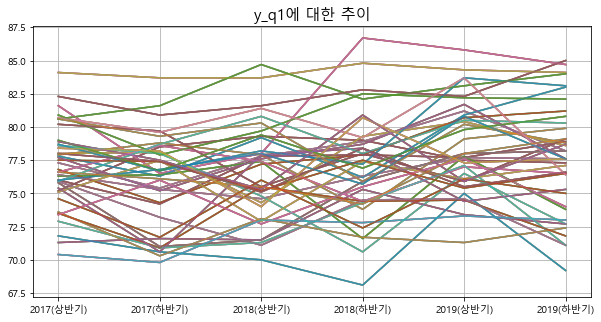

In [98]:
# Q1 에 대한 라인그래프
plt.figure(figsize = (10,5))
plt.title('y_q1에 대한 추이', fontsize = 15)
for pol in yy['jur_stn']:
    d_ = yy[yy['jur_stn'] == pol]
    plt.plot(d_['year'], d_['q1'], label = str(pol), alpha = 0.6)
plt.grid()
#plt.legend(fontsize = 5)
plt.show()

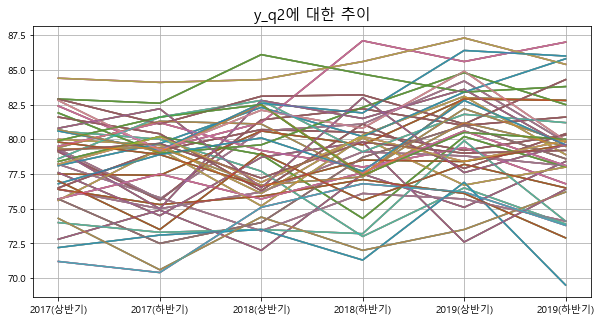

In [99]:
# Q2 에 대한 라인그래프
plt.figure(figsize = (10,5))
plt.title('y_q2에 대한 추이', fontsize = 15)
for pol in yy['jur_stn']:
    d_ = yy[yy['jur_stn'] == pol]
    plt.plot(d_['year'], d_['q2'], label = str(pol), alpha = 0.6)
plt.grid()
plt.show()

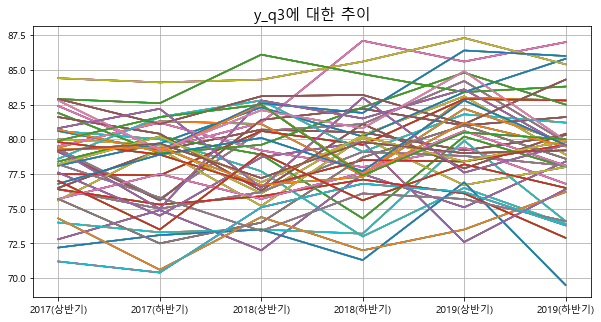

In [97]:
# Q3 에 대한 라인그래프
plt.figure(figsize = (10,5))
plt.title('y_q3에 대한 추이', fontsize = 15)
for pol in yy['jur_stn']:
    d_ = yy[yy['jur_stn'] == pol]
    plt.plot(d_['year'], d_['q2'])
plt.grid()
plt.show()

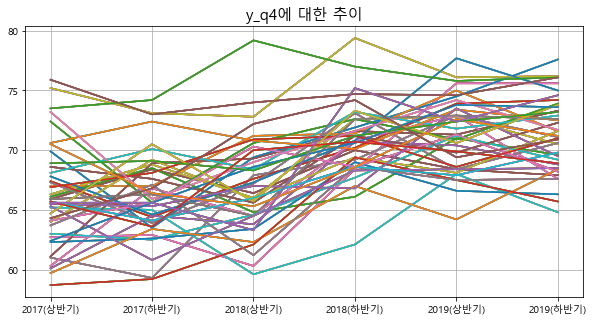

In [100]:
## Q4 에 대한 라인그래프
plt.figure(figsize = (10,5))
plt.title('y_q4에 대한 추이', fontsize = 15)
for pol in yy['jur_stn']:
    d_ = yy[yy['jur_stn'] == pol]
    plt.plot(d_['year'], d_['q4'])
plt.grid()
plt.show()

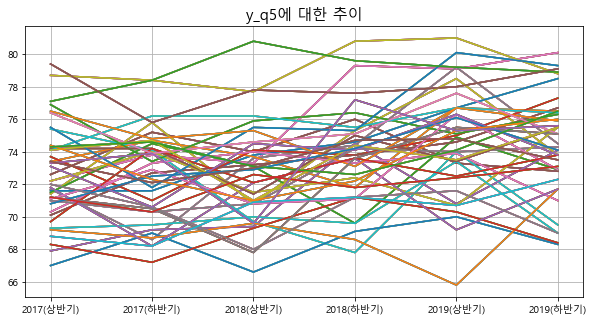

In [101]:
# Q5 에 대한 라인그래프
plt.figure(figsize = (10,5))
plt.title('y_q5에 대한 추이', fontsize = 15)
for pol in yy['jur_stn']:
    d_ = yy[yy['jur_stn'] == pol]
    plt.plot(d_['year'], d_['q5'])
plt.grid()
plt.show()